In [1]:
import os
import sys
sys.path.append('/home/royhirsch/conformal/')

import matplotlib.pyplot as plt
import numpy as np
import utils as utils
from experiment import get_config, run_experiment, predict_and_report_mets, NN

import os
from ml_collections import config_dict
import logging
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from conformal import get_conformal_module, get_percentile, clip_scores
from data import read_and_split, get_dataloader
from trainer import Trainer, get_optimizer, get_scheduler
import utils as utils

ImportError: cannot import name 'get_config' from 'experiment' (/home/royhirsch/conformal/experiment.py)

In [ ]:
def get_config():
    
    cfg = config_dict.ConfigDict()

    # experiment
    cfg.name = '0210_exp3'
    cfg.out_dir = '/home/royhirsch/conformal/exps/tissuemnist'
    cfg.exp_dir = os.path.join(cfg.out_dir, cfg.name)

    cfg.dump_log = False
    cfg.comments = ''
    cfg.gpu_num = 1
    cfg.device = torch.device('cuda:{}'.format(cfg.gpu_num) if torch.cuda.is_available() else 'cpu')
    cfg.seed = 42

    # data
    # cfg.file_name = '/home/royhirsch/conformal/data/embeds_n_logits/imnet1k_r152/valid.pickle'
    cfg.file_name = '/home/royhirsch/conformal/data/embeds_n_logits/aug/medmnist/tissuemnist_test.pickle'
    # cfg.file_name = '/home/royhirsch/conformal/data/embeds_n_logits/aug/imnet1k_r152/100k_train.pickle'
    cfg.label_transform_name = 'none'
    cfg.num_train = 40000
    cfg.num_valid = 3500
    cfg.num_test = 3500
    cfg.batch_size = 128
    cfg.num_workers = 4
    cfg.pin_memory = True
    
    # conformal
    cfg.alpha = 0.1
    cfg.plat_scaling = True
    cfg.conformal_module_name = 'aps'
    cfg.use_score_clipping = True

    # model
    cfg.input_dim = 2048
    cfg.norm = False
    cfg.drop_rate = 0.0
    cfg.hidden_dim = 512

    # optim
    cfg.optimizer_name = 'adamw'
    cfg.scheduler_name = 'none'
    cfg.criteria_name = 'bce'
    cfg.lr = 5e-4
    cfg.wd = 1e-6

    # train
    cfg.num_epochs = 70
    cfg.val_interval = 5
    cfg.save_interval = 200
    cfg.monitor_met_name = 'val_loss'
    
    return cfg


In [2]:
from evaluate import load_pickle, split_data
from conf_tools import get_logits_dataloader, platt_logits
from scipy.special import softmax


def get_dataloaders(config, conformal_module, get_data_func=read_and_split):
    data = get_data_func(config)
    for k, v in data.items():
        logging.info('{} shape: {}'.format(k, v['labels'].shape))

    if config.plat_scaling:
        train_dataloader = get_logits_dataloader(data['train']['preds'],
                                                 data['train']['labels'])
        t = platt_logits(train_dataloader)
        logging.info('Temp is {:.4f}'.format(t))
    else: 
        t = 1.

    dls = {}
    for k, v in data.items():
        v['probs'] = softmax(v['preds'] / t, 1)
        scores = conformal_module.get_scores(v['probs'], v['labels'])
        if k == 'train':
            n = len(scores)
            alpha = 0.1
            qhat = np.quantile(scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
            print(qhat)
        sets = conformal_module.get_sets(scores, v['probs'])
        label = torch.zeros_like(torch.from_numpy(v['probs']))
        for i, s in enumerate(sets):
            label[i, s] = 1

        dl = get_dataloader(v['embeds'], v['probs'], v['labels'],
                            np.asarray(label),
                            batch_size=config.batch_size,
                            shuffle=True if k == 'train' else False,
                            pin_memory=True)
        dls[k] = dl

    return dls, t

NameError: name 'read_and_split' is not defined

In [84]:
config = get_config()
utils.seed_everything(config.seed)
utils.create_logger(config.exp_dir, False)

conformal_module = get_conformal_module(config.conformal_module_name)
dls, t = get_dataloaders(config, conformal_module)
train_dl = dls['train']
valid_dl = dls['valid']
test_dl = dls['test']

# model = NN(input_dim=config.input_dim,
#             hidden_dim=config.hidden_dim,
#             out_dim=8,
#             norm=config.norm,
#             drop_rate=config.drop_rate,
#             criteria_name=config.criteria_name)
# model = model.to(config.device)
# logging.info(model)

# optimizer = get_optimizer(model, config)
# scheduler = get_scheduler(optimizer, config)

# criteria = nn.BCELoss()

# trainer = Trainer(criteria=criteria,
#                     metric_logger=utils.RegressionMetricLogger,
#                     config=config)

# trainer.fit(model=model,
#             train_loader=train_dl,
#             test_loader=valid_dl,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             valid_loader=valid_dl)



INFO - 10/03/23 07:45:20 - 0:00:00 - Created main log at /home/royhirsch/conformal/exps/tissuemnist/0210_exp3/net_launcher_log.log
INFO - 10/03/23 07:45:21 - 0:00:00 - Split 47280 samples to train/val/test : 40000/3500/3500
INFO - 10/03/23 07:45:21 - 0:00:00 - train shape: (40000,)
INFO - 10/03/23 07:45:21 - 0:00:00 - valid shape: (3500,)
INFO - 10/03/23 07:45:21 - 0:00:00 - test shape: (3500,)
  2%|▏         | 2/100 [00:01<01:26,  1.13it/s]
INFO - 10/03/23 07:45:23 - 0:00:02 - Temp is 1.2105
/tmp/ipykernel_106535/140988792.py:26: DeprecationWarning:

the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



0.98639435


In [87]:
# calibrate
from tqdm import tqdm
dl = train_dl
predict_out = trainer.predict(model, dl)
pred_scores = predict_out['pred_scores']
true_scores = predict_out['true_scores']
true_labels = predict_out['cls_labels']
x = np.arange(0, 1, 0.01)
threshs = []
for p, t in tqdm(zip(pred_scores, true_labels)):
    accs = []
    for thresh in x:
        if p[t] <= thresh:
            break
    threshs.append(thresh)


40000it [00:01, 32543.53it/s]


In [95]:
import copy
thresh = 0.3
pred_scores = copy.deepcopy(predict_out['pred_scores'])
pred_scores[predict_out['pred_scores'] < thresh] = 0
pred_scores[predict_out['pred_scores'] >= thresh] = 1

sets = []
for p in pred_scores:
    inds = np.where(p)[0]
    sets.append(inds)
conformal_module.get_conformal_mets(sets, predict_out['cls_labels'])



{'size_mean': 1.736275, 'size_std': 0.9679225818085865, 'acc': 0.904725}

In [81]:
n= len(threshs)
alpha = 0.1
np.quantile(threshs, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')


/tmp/ipykernel_106535/1781739357.py:3: DeprecationWarning:

the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)



0.99

((array([2.0000e+00, 2.0000e+01, 8.2000e+01, 0.0000e+00, 2.1200e+02,
         4.9200e+02, 0.0000e+00, 1.2940e+03, 3.8270e+03, 3.4071e+04]),
  array([0.125 , 0.2125, 0.3   , 0.3875, 0.475 , 0.5625, 0.65  , 0.7375,
         0.825 , 0.9125, 1.    ]),
  <BarContainer object of 10 artists>),
 0.970990625)

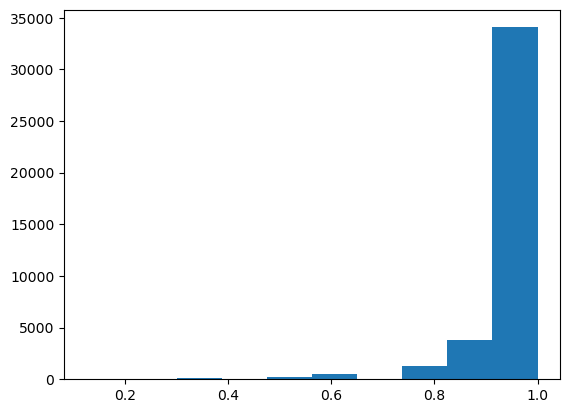

In [56]:
plt.hist(per_sample_res['max_acc']), np.asarray(per_sample_res['max_acc']).mean()

In [53]:
from scipy.special import expit
import copy

dl = train_dl
predict_out = trainer.predict(model, dl)
# predict_out['pred_scores'] = expit(predict_out['pred_scores'])

accs = []
sizes = []
x = np.arange(0.3, 1, 0.01)
# x= [0.6]
for thresh in x:
    pred_scores = copy.deepcopy(predict_out['pred_scores'])
    pred_scores[predict_out['pred_scores'] < thresh] = 0
    pred_scores[predict_out['pred_scores'] >= thresh] = 1

    sets = []
    for p in pred_scores:
        inds = np.where(p)[0]
        sets.append(inds)
    mets = conformal_module.get_conformal_mets(sets, predict_out['cls_labels'])
    accs.append(mets['acc'])
    sizes.append(mets['size_mean'])
    # print(mets['set_size_mean'], mets['acc'])

In [11]:
# import matplotlib.pyplot as plt
# import mplcursors

# # Sample data for the two lines
# y1 = accs
# y2 = sizes

# # Create the first plot with y1 values
# fig, ax1 = plt.subplots()

# # Plot the first line with ax1 (left y-axis)
# line1, = ax1.plot(x, y1, color='b', label='Line 1')
# ax1.set_xlabel('Threshold')
# ax1.set_ylabel('Acc', color='b')
# ax1.tick_params(axis='y', labelcolor='b')
# # ax1.legend(loc='upper left')

# # Create the second y-axis and plot the second line
# ax2 = ax1.twinx()  # instantiate a second y-axis that shares the same x-axis

# # Plot the second line with ax2 (right y-axis)
# line2, = ax2.plot(x, y2, color='r', label='Line 2')
# ax2.set_ylabel('Size', color='r')
# ax2.tick_params(axis='y', labelcolor='r')
# # ax2.legend(loc='upper right')

# mplcursors.cursor([line1, line2], hover=True)

# # Show the plot
# plt.title('Acc and mean size for different thresholds')
# ax1.grid(True)
# plt.show()

In [54]:
import plotly.graph_objects as go

# Sample data for the two lines
y1 = accs
y2 = sizes

# Create the first y-axis trace (line 1)
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Acc', yaxis='y1')

# Create the second y-axis trace (line 2)
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Size', yaxis='y2')

# Create layout with two y-axes and unified hover mode
layout = go.Layout(title='Acc and mean size for different thresholds (train)',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y1-axis', side='left', showgrid=False),
                   yaxis2=dict(title='Y2-axis', side='right', overlaying='y', showgrid=False),
                   hovermode='x unified')  # Enable unified hover mode for x-axis

# Create figure and plot it
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [16]:
import plotly.graph_objects as go

# Sample data for the two lines
y1 = accs
y2 = sizes

# Create the first y-axis trace (line 1)
trace1 = go.Scatter(x=x, y=y1, mode='lines', name='Acc', yaxis='y1')

# Create the second y-axis trace (line 2)
trace2 = go.Scatter(x=x, y=y2, mode='lines', name='Size', yaxis='y2')

# Create layout with two y-axes and unified hover mode
layout = go.Layout(title='Acc and mean size for different thresholds (test)',
                   xaxis=dict(title='X-axis'),
                   yaxis=dict(title='Y1-axis', side='left', showgrid=False),
                   yaxis2=dict(title='Y2-axis', side='right', overlaying='y', showgrid=False),
                   hovermode='x unified')  # Enable unified hover mode for x-axis

# Create figure and plot it
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


Text(0, 0.5, 'MSE Loss')

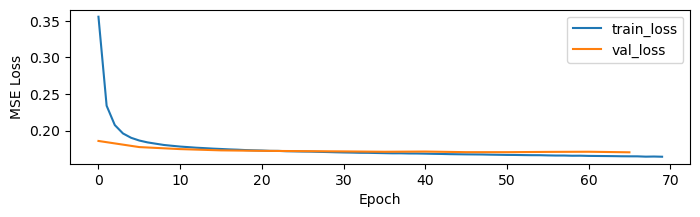

In [14]:
history = trainer.history
plt.figure(figsize=(8, 2))
plt.plot(np.arange(len(history['loss'])), history['loss'], label='train_loss')
plt.plot( np.arange(0, len(history['loss']), config.val_interval), history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')